In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
from tensorflow.keras.applications import ResNet50

import warnings
warnings.filterwarnings("ignore")

C:\Users\Asus\anaconda3\envs\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [3]:
def test_df(ts_path):
    classes = []
    class_paths = []
    files = os.listdir(ts_path)
    for file in files:
        label_dir = os.path.join(ts_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [4]:
tr_df = train_df('Training')

In [5]:
tr_df

,Class Path,Class
0,Training\glioma\Tr-glTr_0000.jpg,glioma
1,Training\glioma\Tr-glTr_0001.jpg,glioma
2,Training\glioma\Tr-glTr_0002.jpg,glioma
3,Training\glioma\Tr-glTr_0003.jpg,glioma
4,Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Training\pituitary\Tr-pi_1455.jpg,pituitary


In [6]:
ts_df = test_df('Testing')

In [7]:
ts_df

,Class Path,Class
0,Testing\glioma\Te-glTr_0000.jpg,glioma
1,Testing\glioma\Te-glTr_0001.jpg,glioma
2,Testing\glioma\Te-glTr_0002.jpg,glioma
3,Testing\glioma\Te-glTr_0003.jpg,glioma
4,Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1305,Testing\pituitary\Te-pi_0295.jpg,pituitary
1306,Testing\pituitary\Te-pi_0296.jpg,pituitary
1307,Testing\pituitary\Te-pi_0297.jpg,pituitary
1308,Testing\pituitary\Te-pi_0298.jpg,pituitary


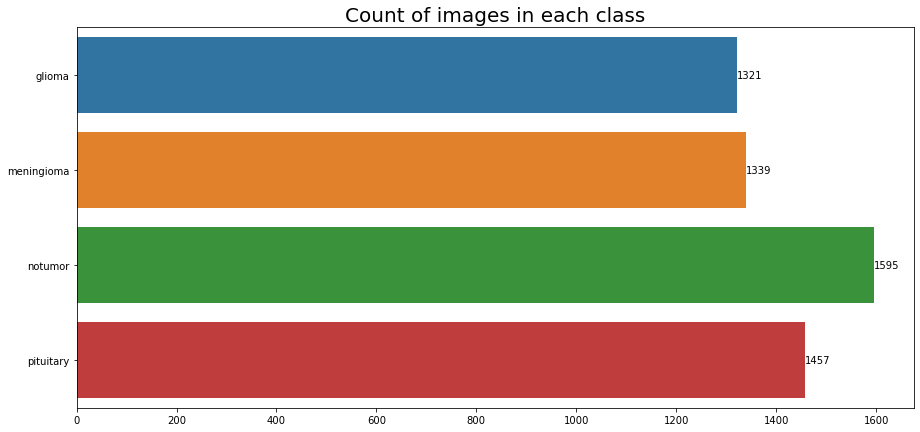

In [8]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

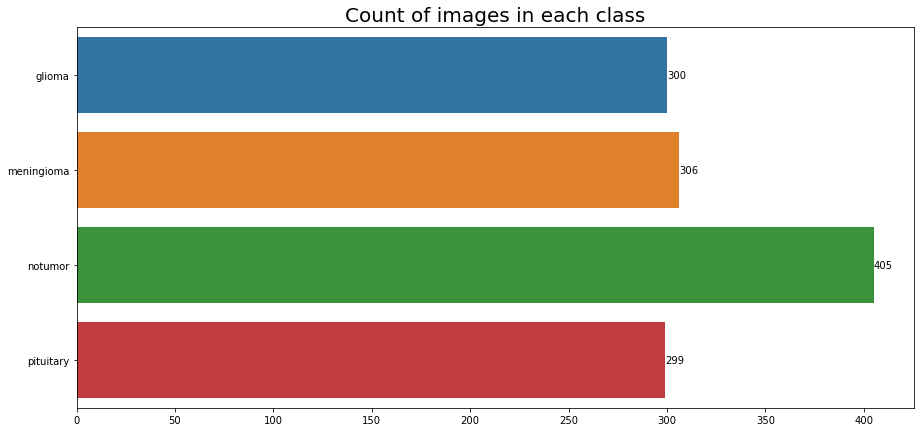

In [9]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df , y=ts_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [10]:
valid_df, ts_df = train_test_split(ts_df, train_size=.5, random_state=20)

In [11]:
valid_df

,Class Path,Class
464,Testing\meningioma\Te-me_0164.jpg,meningioma
987,Testing\notumor\Te-no_0381.jpg,notumor
565,Testing\meningioma\Te-me_0265.jpg,meningioma
503,Testing\meningioma\Te-me_0203.jpg,meningioma
502,Testing\meningioma\Te-me_0202.jpg,meningioma
...,...,...
1242,Testing\pituitary\Te-pi_0232.jpg,pituitary
924,Testing\notumor\Te-no_0318.jpg,notumor
1247,Testing\pituitary\Te-pi_0237.jpg,pituitary
271,Testing\glioma\Te-gl_0271.jpg,glioma


In [12]:
batch_size = 16
img_size = (299,299)

tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))

gen = ImageDataGenerator()


tr_gen = tr_gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                 y_col='Class',batch_size=batch_size,
                                 target_size=img_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                    y_col='Class',batch_size=batch_size,
                                    target_size=img_size)

ts_gen = gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                y_col='Class',batch_size=batch_size,
                                 target_size=img_size,shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


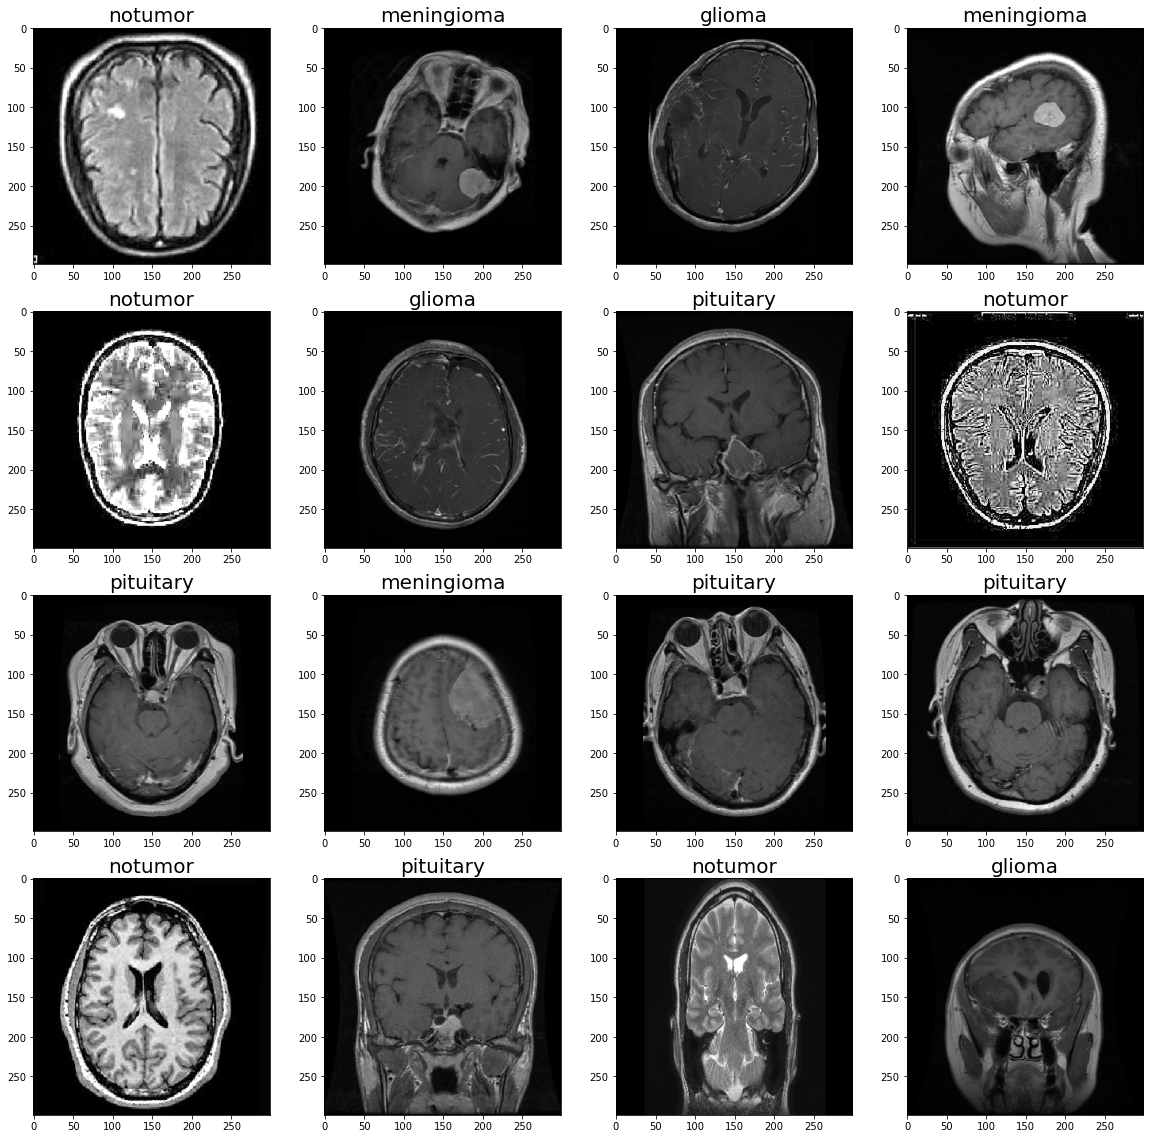

In [13]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='k', fontsize=20)
plt.show()

In [14]:
# Set the input shape for ResNet50
img_shape = (299, 299, 3)

# Load ResNet50 as the base model
# if we set (incluse_top=False) then we don't need to specify the image_shape
# Be default it will be (224, 224, )
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

# Uncomment the following lines if you want to freeze the layers
# for layer in base_model.layers:
#     layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(64, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Display the model summary
model.summary()



94765736/94765736 [==============================] - 9s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                       

## Complex ResNet model with different activation functions and more layers

ReLU is a simple and widely used activation function that replaces all negative values with zero. It is computationally efficient and helps with the vanishing gradient problem.


ELU is an extension of ReLU that addresses the issue of dead neurons (neurons that always output zero) by allowing negative values with a smooth curve. It has been shown to reduce training time and improve performance.


SELU is a variant of ELU with a specific scaling factor. It is designed to maintain a stable mean and variance during training, making it particularly suitable for deep neural networks. SELU has the property of self-normalization, which can lead to more robust training.

<code>
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import ResNet50

#Set the input shape for ResNet50
img_shape = (299, 299, 3)

#Load ResNet50 as the base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

#Uncomment the following lines if you want to freeze the layers
#for layer in base_model.layers:
#layer.trainable = False

#Build the more complex model with different activation functions
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu'),  # Using ReLU
    Dropout(rate=0.5),
    BatchNormalization(),
    Dense(128, activation='elu'),  # Using ELU
    Dropout(rate=0.4),
    BatchNormalization(),
    Dense(64, activation='selu'),  # Using SELU
    Dropout(rate=0.3),
    Dense(4, activation='softmax')
])

#Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

#Display the model summary
model.summary()

    
</code>

In [15]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10


357/357 [==============================] - 1585s 4s/step - loss: 0.9304 - accuracy: 0.7700 - precision: 0.8380 - recall: 0.6980 - val_loss: 0.4510 - val_accuracy: 0.8641 - val_precision: 0.8862 - val_recall: 0.8321
Epoch 2/10
357/357 [==============================] - 1525s 4s/step - loss: 0.3030 - accuracy: 0.8953 - precision: 0.9224 - recall: 0.8675 - val_loss: 0.3739 - val_accuracy: 0.8962 - val_precision: 0.9009 - val_recall: 0.8885
Epoch 3/10
357/357 [==============================] - 1554s 4s/step - loss: 0.2344 - accuracy: 0.9221 - precision: 0.9408 - recall: 0.9049 - val_loss: 0.1953 - val_accuracy: 0.9206 - val_precision: 0.9262 - val_recall: 0.9191
Epoch 4/10
357/357 [==============================] - 1671s 5s/step - loss: 0.2061 - accuracy: 0.9263 - precision: 0.9446 - recall: 0.9170 - val_loss: 0.1346 - val_accuracy: 0.9557 - val_precision: 0.9626 - val_recall: 0.9435
Epoch 5/10
357/357 [==============================] - 1699s 5s/step - loss: 0.2143 - accuracy:

In [16]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

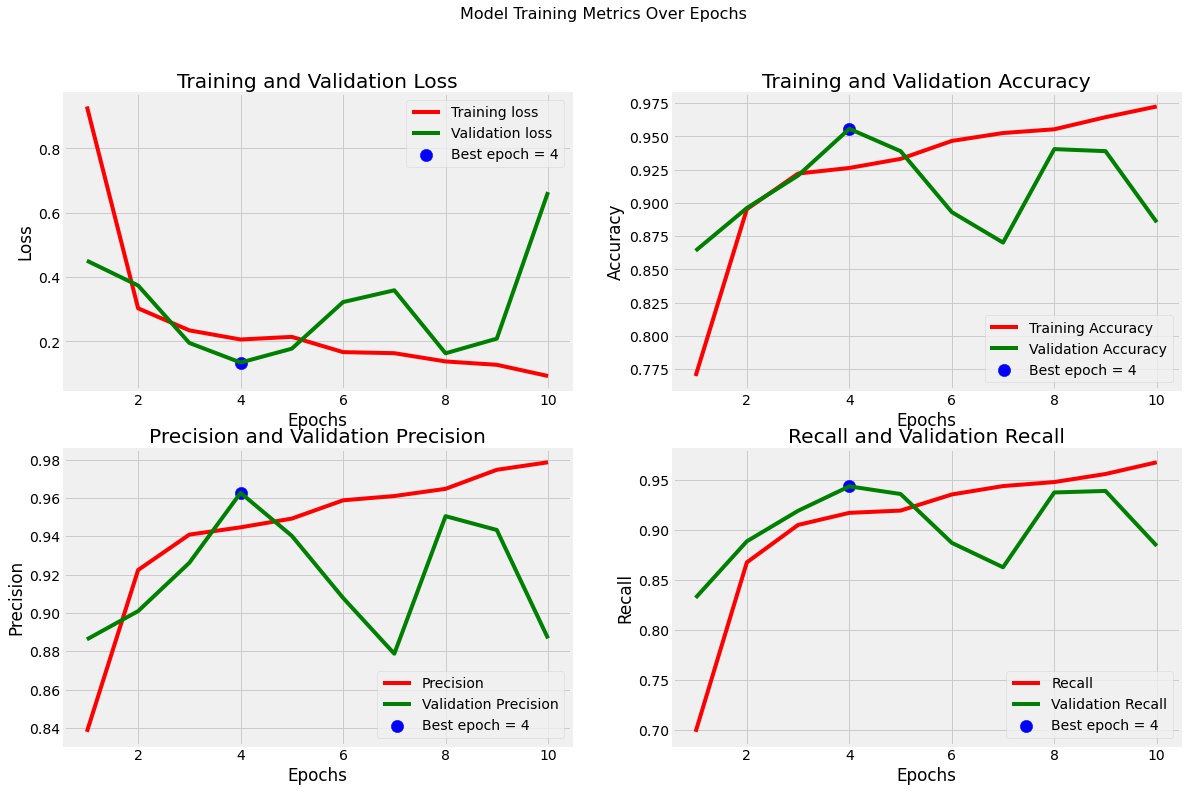

In [17]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()


In [18]:
train_score = model.evaluate(tr_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(ts_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 48s 1s/step - loss: 0.5315 - accuracy: 0.8947 - precision: 0.8960 - recall: 0.8947
Train Loss:  0.3922920525074005
Train Accuracy:  0.9114145636558533
--------------------
Validation Loss:  0.664350688457489
Validation Accuracy:  0.885496199131012
--------------------
Test Loss:  0.5315131545066833
Test Accuracy:  0.8946564793586731


In [19]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 46s 1s/step


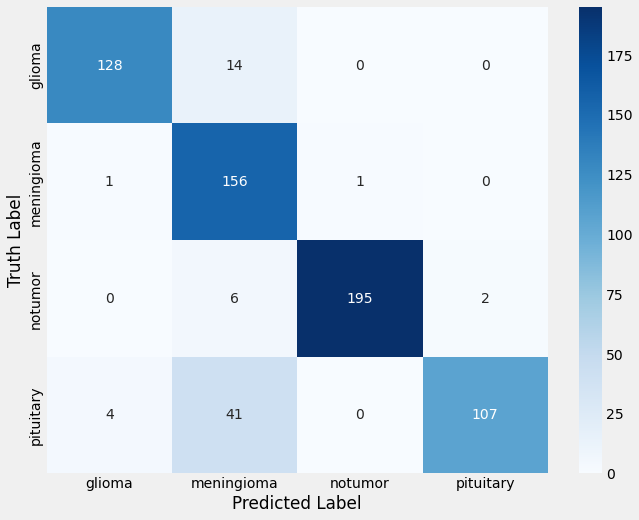

In [20]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [21]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       142
           1       0.72      0.99      0.83       158
           2       0.99      0.96      0.98       203
           3       0.98      0.70      0.82       152

    accuracy                           0.89       655
   macro avg       0.91      0.89      0.89       655
weighted avg       0.92      0.89      0.90       655



In [22]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 1s 881ms/step


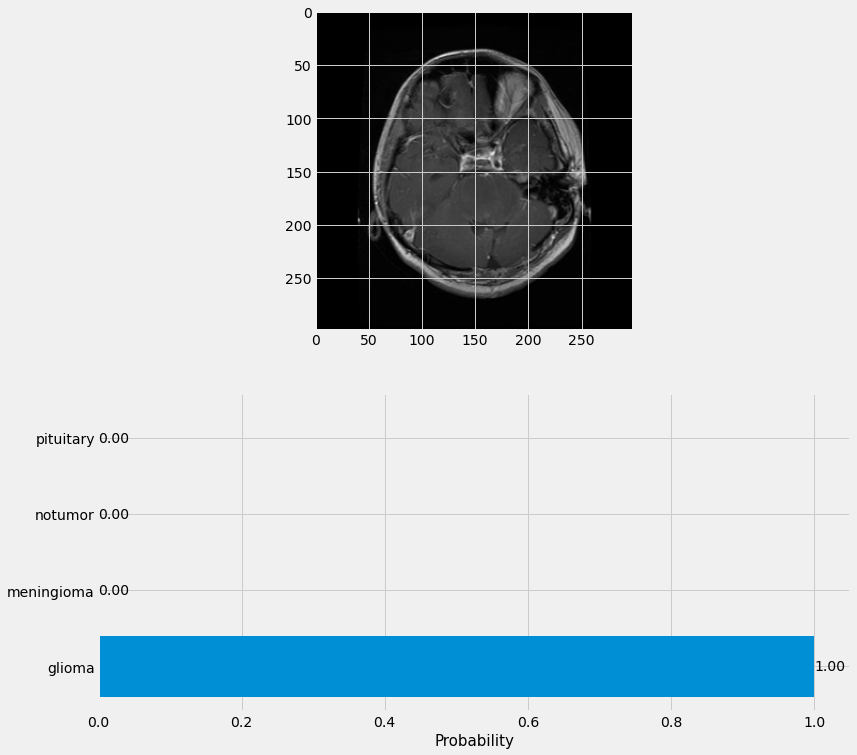

In [23]:
predict('Testing/glioma/Te-gl_0010.jpg')

In [24]:
model.save("brain_tumor_model(ResNet50).h5")